## Exploratory Data Analysis

This notebook explores the structure of the PHEME Rumor Non-Rumor dataset to find potentially useful features in a classifier.

In [4]:
# Import dependencies for this notebook
import pandas as pd

import numpy as np
import networkx as nx
import seaborn as sns  # Must be seaborn-0.9.0
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from lib.util import fetch_tweets, to_unix_tmsp

In [3]:
tweets = fetch_tweets("germanwings-crash")
tweets[["is_source_tweet","is_rumor"]] = tweets[["is_source_tweet", "is_rumor"]].astype(bool)
tweets.created = pd.to_datetime(tweets.created * 1e6)
tweets.describe()
#tweets[tweets["user.created_at"].isnull()]
#tweets = tweets[tweets["event"] == "germanwings-crash"]

,thread,in_reply_tweet,tweet_id,in_reply_user,user_id,tweet_length,symbol_count,user_mentions,urls_count,media_count,...,user.handle_length,user.name_length,user.notifications,user.friends_count,user.has_bg_img,user.default_pic,user.location,user.profile_sbcolor,user.profile_bgcolor,user.utc_dist
count,4.489000e+03,4.019000e+03,4.489000e+03,4.020000e+03,4.489000e+03,4489.000000,4489.0,4489.000000,4489.000000,4489.000000,...,4489.000000,4489.000000,4489.0,4489.000000,4489.000000,4489.000000,4489.000000,4.489000e+03,4.489000e+03,2969.000000
mean,5.806348e+17,5.806699e+17,5.806866e+17,4.549064e+08,8.101660e+08,90.788372,0.0,1.506572,0.185787,0.127423,...,11.704834,10.434172,0.0,1576.522834,0.889285,0.370238,0.724215,1.117811e+07,9.096543e+06,3.905945
std,4.321150e+14,4.582938e+14,4.778257e+14,8.164223e+08,1.026355e+09,39.920378,0.0,1.020736,0.400827,0.334150,...,4.375173,2.663997,0.0,8865.247468,0.313814,0.482922,0.446959,5.620359e+06,5.702912e+06,3.112538
min,5.803176e+17,5.803176e+17,5.803176e+17,4.283330e+05,5.096300e+04,5.000000,0.0,0.000000,0.000000,0.000000,...,1.000000,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,5.803285e+17,5.803324e+17,5.803364e+17,1.551360e+07,5.894135e+07,56.000000,0.0,1.000000,0.000000,0.000000,...,9.000000,8.000000,0.0,184.000000,1.000000,0.000000,0.000000,1.106124e+07,1.710879e+06,1.000000
50%,5.803504e+17,5.803583e+17,5.803671e+17,8.289233e+07,2.754502e+08,97.000000,0.0,1.000000,0.000000,0.000000,...,12.000000,10.000000,0.0,448.000000,1.000000,0.000000,1.000000,1.263998e+07,1.263998e+07,5.000000
75%,5.811325e+17,5.812138e+17,5.812040e+17,3.687107e+08,1.344572e+09,130.000000,0.0,2.000000,0.000000,0.000000,...,15.000000,12.000000,0.0,1210.000000,1.000000,1.000000,1.000000,1.565873e+07,1.263998e+07,6.000000
max,5.815507e+17,5.826598e+17,5.833613e+17,3.114712e+09,3.114712e+09,151.000000,0.0,12.000000,2.000000,2.000000,...,20.000000,15.000000,0.0,453460.000000,1.000000,1.000000,1.000000,1.677722e+07,1.677722e+07,12.000000


## Ratio of Rumor to Non-Rumor

Since this project is concerned with classifying rumor and non-rumor tweets, we need to know what the proportion of rumor to non-rumor tweets for each event in the PHEME dataset.

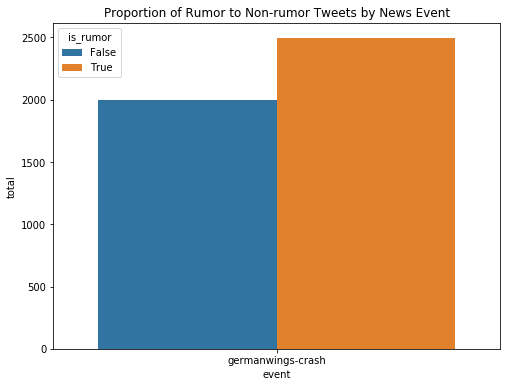

In [4]:
twts_event_rumor = tweets[["event", "tweet_id", "is_rumor"]].groupby(["event", "is_rumor"]) \
    .agg(len) \
    .rename(columns={"tweet_id": "total"}) \
    .reset_index()

plt.figure(figsize=(8,6))
plt.title("Proportion of Rumor to Non-rumor Tweets by News Event")
ax = sns.barplot(x="event", y="total", hue="is_rumor", data=twts_event_rumor)

In [5]:
tweets
# Z = (data - data.mean()) / data.std()  # normalaize
# X = pd.concat([y, Z.iloc[:,0:12]], axis=1)
# X = pd.melt(X, id_vars="is_rumor", var_name="features", value_name="value")
# plt.figure(figsize=(12,12))
# sns.violinplot(x="features", y="value", hue="is_rumor", data=X, split=True, inner="quart")
# plt.xticks(rotation=90)

,is_rumor,thread,in_reply_tweet,event,tweet_id,is_source_tweet,in_reply_user,user_id,tweet_length,symbol_count,...,user.notifications,user.friends_count,user.time_zone,user.has_bg_img,user.default_pic,user.created_at,user.location,user.profile_sbcolor,user.profile_bgcolor,user.utc_dist
0,False,580319983676313600,NaN,germanwings-crash,580319983676313601,True,NaN,8330472,98,0,...,0,74,Madrid,1,0,2007-08-21 14:03:19,1,16777215,11453380,0.0
1,False,580319983676313600,5.803200e+17,germanwings-crash,580322851850461184,False,8.330472e+06,2307392966,109,0,...,0,1782,None,1,1,2014-01-23 23:26:57,1,12639981,12639981,NaN
10,False,580322102307373056,5.803221e+17,germanwings-crash,580349597937213440,False,1.621157e+07,40643525,143,0,...,0,63,Athens,1,1,2009-05-17 11:10:29,1,12639981,12639981,2.0
100,False,580324804403818496,5.803700e+17,germanwings-crash,580377215667310592,False,6.143144e+07,3028982049,132,0,...,0,218,None,1,1,2015-02-10 23:27:50,1,12639981,12639981,NaN
1000,False,580341214098137088,5.803412e+17,germanwings-crash,580353017402245121,False,1.453758e+09,2843470199,97,0,...,0,11,None,1,1,2014-10-25 10:29:55,0,12639981,12639981,NaN
1001,False,580341214098137088,5.803412e+17,germanwings-crash,580361567298019328,False,1.453758e+09,2274900940,12,0,...,0,183,None,1,1,2014-01-11 14:11:01,0,12639981,12639981,NaN
1002,False,580341214098137088,5.803412e+17,germanwings-crash,580364950188777472,False,1.453758e+09,2861054237,10,0,...,0,61,None,1,1,2014-11-04 17:37:20,0,12639981,12639981,NaN
1003,False,580341214098137088,5.803412e+17,germanwings-crash,580377134633508866,False,1.453758e+09,2910882671,89,0,...,0,9,None,1,1,2014-12-08 12:47:19,0,12639981,12639981,NaN
1004,False,580341214098137088,5.803412e+17,germanwings-crash,580383360322826241,False,1.453758e+09,3020252511,22,0,...,0,95,None,1,1,2015-02-05 18:47:51,0,12639981,12639981,NaN
1005,False,580341214098137088,5.803412e+17,germanwings-crash,580416076305010688,False,1.453758e+09,2743845665,10,0,...,0,35,None,1,1,2014-08-15 20:59:43,0,12639981,12639981,NaN


## Tweet Frequency Over Time

It seems plausable that immediately after a news event, the number of rumor tweets would be greater than the number of non-rumor tweets as the facts start getting sorted out. So we examined the count of rumor and non-rumor tweets per hour over time.

In [6]:
# Germanwings Crash
tweets.created.describe()

count                    4489
unique                   4259
top       2015-03-24 11:02:33
freq                        4
first     2015-03-24 10:37:41
last      2015-04-01 20:12:15
Name: created, dtype: object

In the Germanwings Crash dataset, the first relevant tweet was recorded on March 24, 2015, which is the date of the actual event. Tweets related to the event were collected for the next eight days.

Text(0.5,0,'Tweet Date')

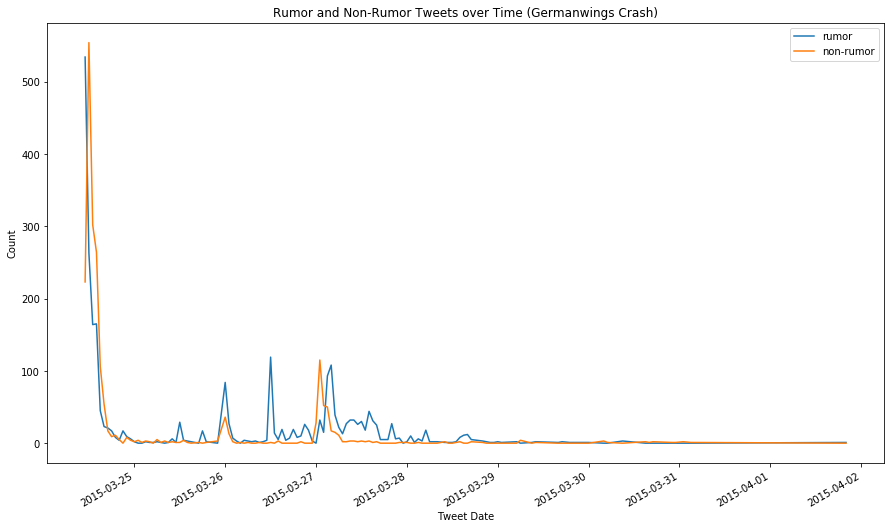

In [7]:
twt_freq = tweets
twt_freq.created = twt_freq.created.dt.round("H")

def f(x):
    rumor = sum(x["is_rumor"])
    total = len(x["is_rumor"])
    d = [rumor, total - rumor]
    return pd.Series(d, index=["rumor", "non-rumor"])

twt_freq = twt_freq[["created", "is_rumor"]].groupby("created").apply(f)
ax = twt_freq.plot(figsize=(15,9),
            title="Rumor and Non-Rumor Tweets over Time (Germanwings Crash)")
ax.set_ylabel("Count")
ax.set_xlabel("Tweet Date")

In the case of the Germanwings Crash, we see both rumor and non-rumor tweets quickly trail out in long tails overtime. However, rumor tweets seem to spike after the initial day more frequently than non-rumor tweets.

In [62]:
from IPython.display import IFrame
IFrame("html/gw_beeswarm.html", width="100%", height=650)

## Thread Structures

One reason to use a classifier on tweet threads instead of individual tweets is that the conversation constitutes a graph structure where additional features can be extracted that can't when tweets are considered in isolation. For each event, most of the tweets are replies to other tweets.

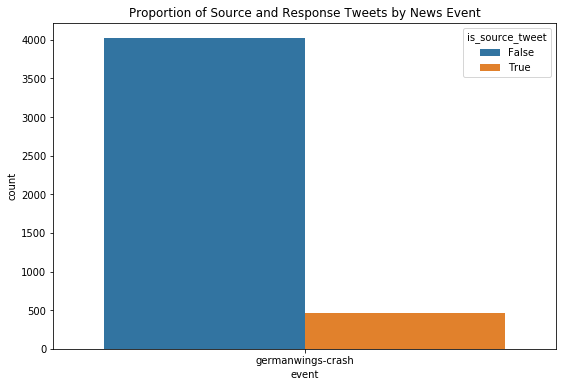

In [8]:
plt.figure(figsize=(9,6))
plt.title("Proportion of Source and Response Tweets by News Event")
ax = sns.countplot(x="event", hue="is_source_tweet", data=tweets)

As the histogram above shows, there are many more tweets in reply to a tweet than other source tweet. This may mean that there may be some interesting features to exploit in a machine learning classifier based on the graph structure of these Twitter conversations.

## Exploring the Conversational Network Structure

Tweets in the PHEME dataset are organized into threads, proxies for conversations threads. When one tweet replies to another, it constitutes a thread. Since the vast majority of tweets in this dataset are replies to other tweets, we examined the distribution of *thread length*, the number of individual tweets in a thread.

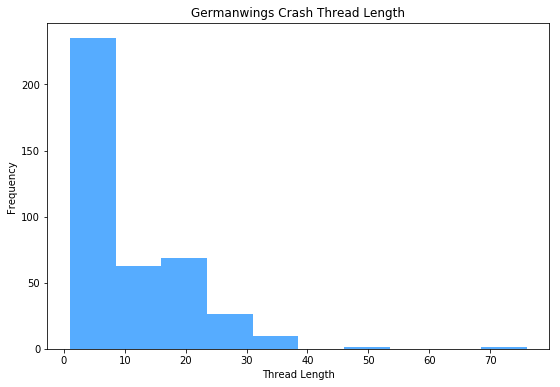

In [9]:
relations = tweets[tweets["is_source_tweet"] == False][["thread", "user_id", "in_reply_user", "tweet_id", "in_reply_tweet", "is_rumor"]]

thread_lengths = [
    relations[["thread", "tweet_id"]].groupby("thread").agg(len)['tweet_id']
]

thread_lengths_list = [ thread.tolist() for thread in thread_lengths ]

for event in thread_lengths:
    event.plot(kind="hist", color="dodgerblue", alpha=0.75, figsize=(9,6))
    plt.title("Germanwings Crash Thread Length")
    plt.xlabel("Thread Length")

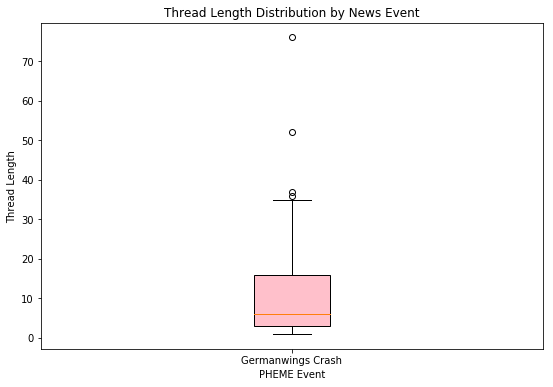

In [10]:
fig, axes = plt.subplots(figsize=(9,6))

bplot = axes.boxplot(thread_lengths_list, patch_artist=True)

for patch, color in zip(bplot["boxes"], ["pink"]):
    patch.set_facecolor(color)

axes.set_xlabel("PHEME Event")
axes.set_ylabel("Thread Length")
axes.set_title("Thread Length Distribution by News Event")

plt.setp(axes, xticks=[y+1 for y in range(len(thread_lengths_list))], xticklabels=["Germanwings Crash"])

plt.show()

## Combining Structure and Rumor


In [11]:
def graph_connections(edgelist, title):
    colorPal = {"rumor": "blue", "nonrumor": "green"}
    G = nx.from_pandas_edgelist(edgelist, "user_id", "in_reply_user")
    pos = nx.layout.spring_layout(G)

    rumor_to_color = lambda rumor : colorPal['rumor'] if rumor == True else colorPal['nonrumor']
    node_colors = [rumor_to_color(val) for val in edgelist['is_rumor']]

    nodes = nx.draw_networkx_nodes(G, pos,
                               node_color=node_colors,
                               node_size=10)

    edges = nx.draw_networkx_edges(G, pos,
                                arrowsize=30, 
                                width=1)

    ax = plt.gca()
    ax.set_axis_off()
    ax.set_title(title)

    legend_elements = [
        Line2D([0],[0], marker='o', markerfacecolor=colorPal['rumor'], label="Rumor", color='slategray', markersize=10),
        Line2D([0],[0], marker='o', markerfacecolor=colorPal['nonrumor'], label="Non-Rumor", color='slategray', markersize=10)    
    ]

    ax.legend(handles=legend_elements)
    plt.figure(figsize=(15,9))
    plt.show()

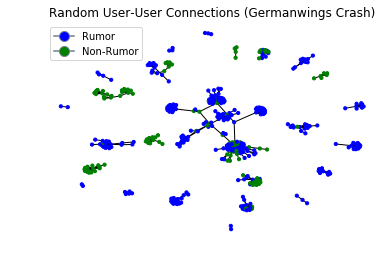

<Figure size 1080x648 with 0 Axes>

In [12]:
random_threads = relations[["thread", "user_id"]] \
    .groupby("thread") \
    .agg(pd.Series.nunique) \
    .sample(50, random_state=2)
random_connections = relations[relations.thread.isin(list(random_threads.index))]
graph_connections(random_connections, "Random User-User Connections (Germanwings Crash)")

We start to see some interesting patterns in the user-to-user response network in a thread.

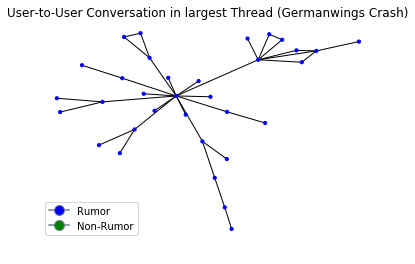

<Figure size 1080x648 with 0 Axes>

In [13]:
largest_threads = relations[["thread", "user_id"]] \
    .groupby("thread") \
    .agg(pd.Series.nunique) \
    .sort_values("user_id", ascending=False) \
    [0:1]

dense_connections = relations[relations["thread"].isin(list(largest_threads.index))]
graph_connections(dense_connections, "User-to-User Conversation in largest Thread (Germanwings Crash)")

This visualization lends itself to two possibly interesting features:

1. The number of components per thread.
2. The diameter of the largest component.
